In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load Superstore dataset 
df = pd.read_csv('SampleSuperstoreClean.csv')

In [13]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Profit Margin'] = df['Profit'] / df['Sales']

Regional Performance Test (Sales)
H₀: Sales distributions are equal across all regions.
H₁: Sales distributions differ across regions.
Normality (D'Agostino K², South, n=1620): Failed (p=0.0000)
Normality (D'Agostino K², West, n=3203): Failed (p=0.0000)
Normality (D'Agostino K², Central, n=2323): Failed (p=0.0000)
Normality (D'Agostino K², East, n=2848): Failed (p=0.0000)
Normality test failed for at least one group.
Homogeneity of Variances (Levene): Passed
Kruskal-Wallis: Statistic=26.10, p=0.0000
Conclusion: Reject H₀; sales differ significantly across regions, supporting investment in high-performing regions (West, East).

Significant Region Pairs (Dunn's Test):
Central vs East: p=0.0076
Central vs West: p=0.0000
East vs Central: p=0.0076
West vs Central: p=0.0000
Post-hoc Conclusion: Significant p-values (<0.05) indicate specific region pairs (e.g., West vs. Central) differ, guiding targeted investment.

Ranking of Regions by Median Sales:
West: 60.84
East: 54.90
South: 54.59
Cent

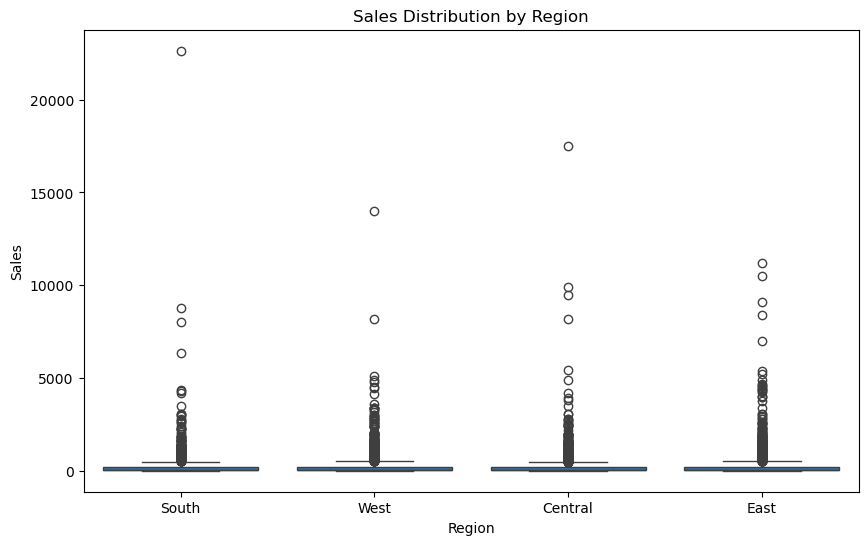

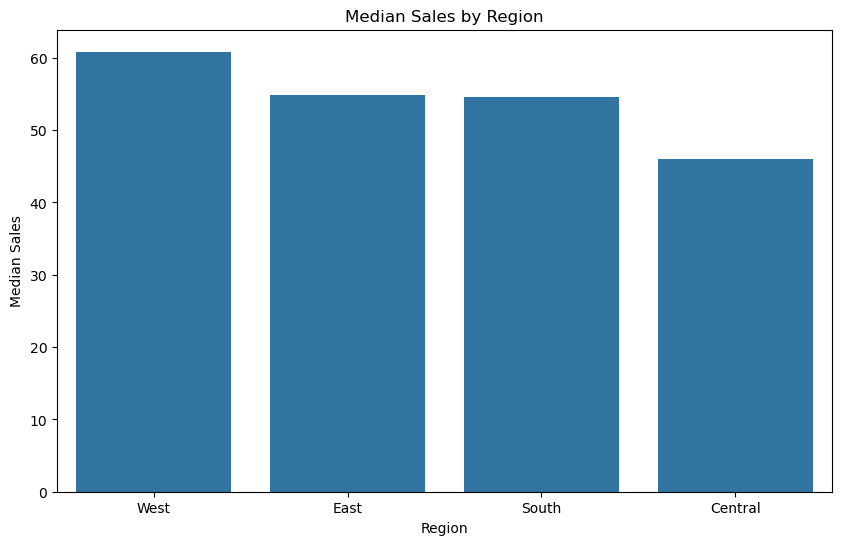

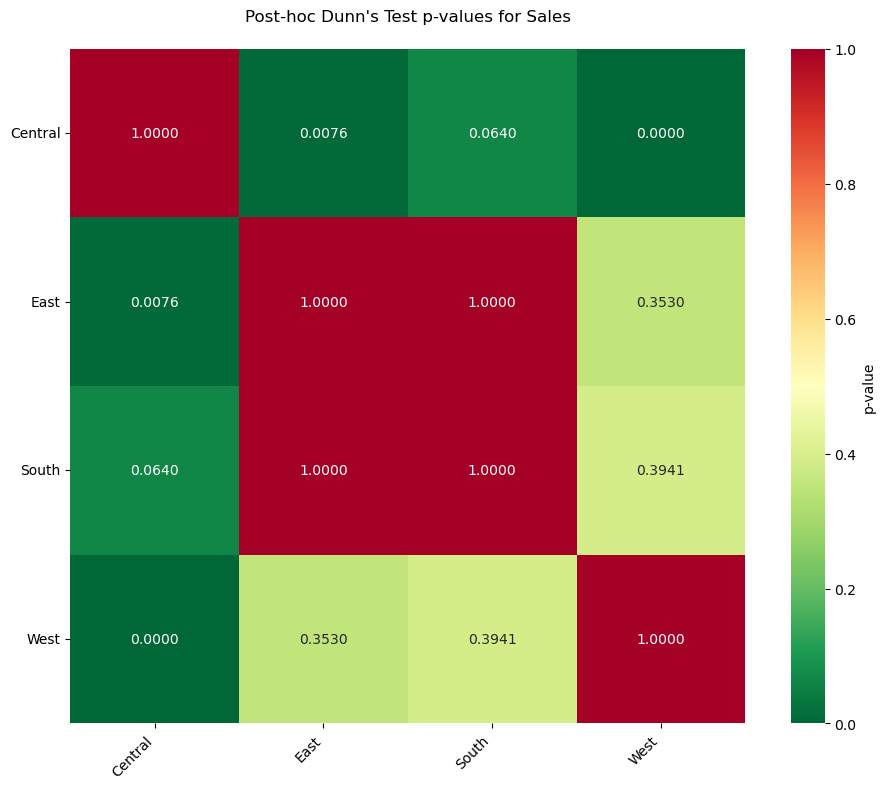


Regional Performance Test (Profit)
H₀: Profit distributions are equal across all regions.
H₁: Profit distributions differ across regions.
Normality (D'Agostino K², South, n=1620): Failed (p=0.0000)
Normality (D'Agostino K², West, n=3203): Failed (p=0.0000)
Normality (D'Agostino K², Central, n=2323): Failed (p=0.0000)
Normality (D'Agostino K², East, n=2848): Failed (p=0.0000)
Normality test failed for at least one group.
Homogeneity of Variances (Levene): Failed
Kruskal-Wallis: Statistic=227.90, p=0.0000
Conclusion: Reject H₀; profits differ significantly across regions, supporting investment in West/East.

Significant Region Pairs (Dunn's Test):
Central vs East: p=0.0000
Central vs South: p=0.0000
Central vs West: p=0.0000
East vs Central: p=0.0000
East vs West: p=0.0000
South vs Central: p=0.0000
South vs West: p=0.0012
West vs Central: p=0.0000
West vs East: p=0.0000
West vs South: p=0.0012
Post-hoc Conclusion: Significant p-values (<0.05) indicate specific region pairs differ, rein

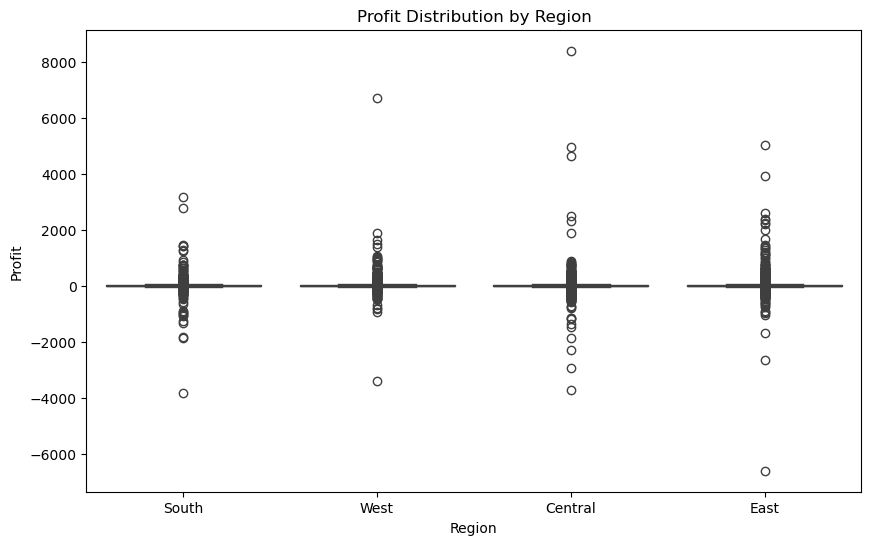

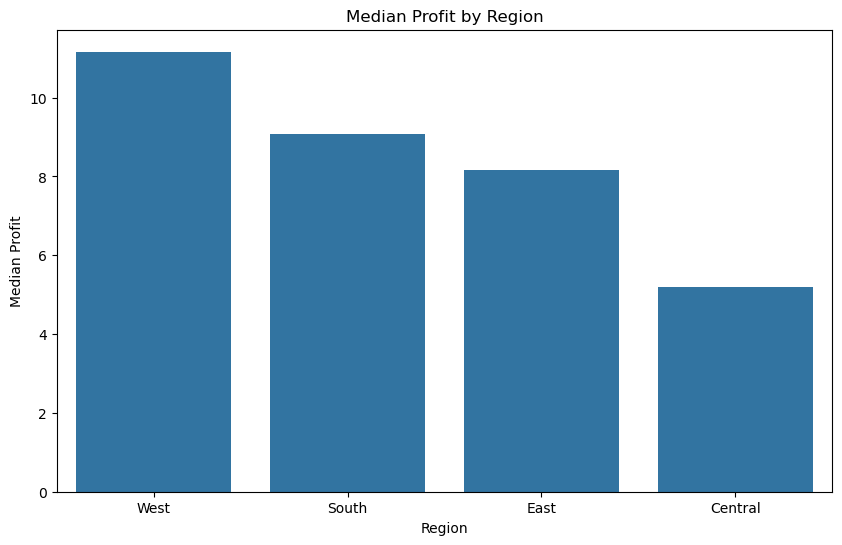

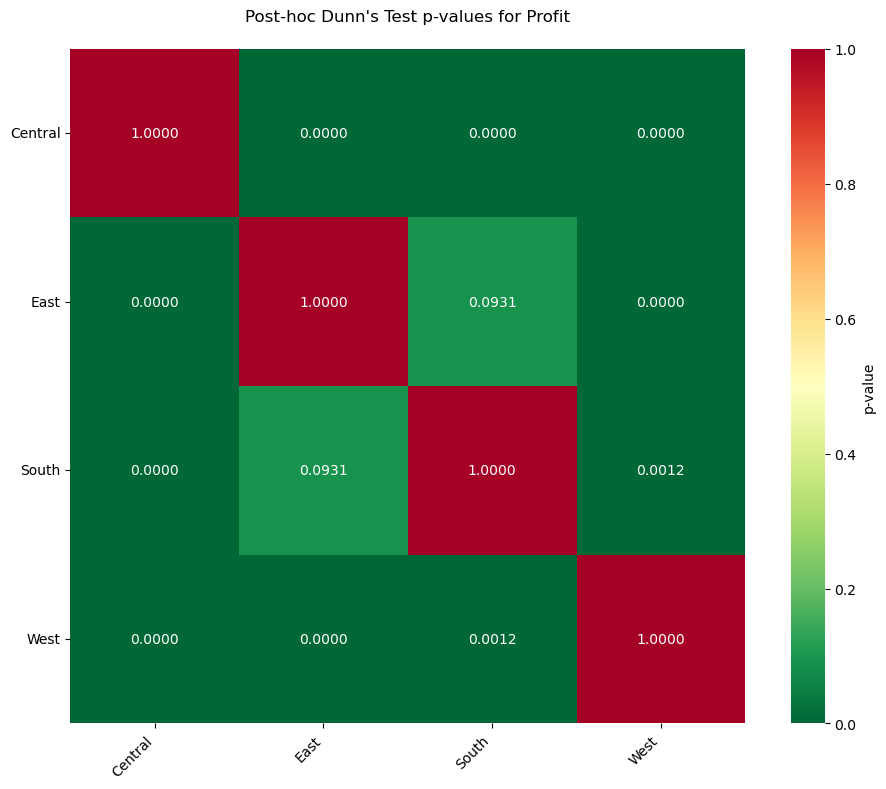

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Set random seed
np.random.seed(42)

alpha = 0.05

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    # Check normality for each group
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality ({name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:  # Shapiro-Wilk for smaller samples
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:  # D'Agostino K² for larger samples
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, {name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    # Aggregate normality
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one group.")
    
    # Check homogeneity of variances
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    # Force Kruskal-Wallis if any group has n < 3
    if any(len(group) < 3 for group in data_groups):
        print("At least one group has insufficient data (<3); defaulting to Kruskal-Wallis.")
        return False
    
    return normality and homogeneity

def summarize_post_hoc(post_hoc, group_names):
    """Summarize significant pairs from post-hoc tests."""
    if isinstance(post_hoc, pd.DataFrame):  # Dunn's test
        significant_pairs = post_hoc[post_hoc < alpha].stack()
        if not significant_pairs.empty:
            print("\nSignificant Region Pairs (Dunn's Test):")
            for (region1, region2), p in significant_pairs.items():
                print(f"{region1} vs {region2}: p={p:.4f}")
        else:
            print("\nNo significant region pairs (Dunn's Test).")
        return post_hoc
    else:  # Tukey HSD
        df_post_hoc = post_hoc.summary()
        significant_pairs = [(row[1], row[2], row[6]) for row in df_post_hoc.data if row[6] < alpha]
        if significant_pairs:
            print("\nSignificant Region Pairs (Tukey HSD):")
            for group1, group2, p in significant_pairs:
                print(f"{group1} vs {group2}: p={p:.4f}")
        else:
            print("\nNo significant region pairs (Tukey HSD).")
        return None

def rank_regions(df, metric, group_col='Region'):
    """Rank regions by median metric (sales/profit) and return medians."""
    medians = df.groupby(group_col)[metric].median().sort_values(ascending=False)
    print(f"\nRanking of Regions by Median {metric}:")
    for region, median in medians.items():
        print(f"{region}: {median:.2f}")
    return medians

def plot_median_bar(medians, metric, title, filename):
    """Plot bar chart for median rankings."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=medians.index, y=medians.values)
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()


def plot_post_hoc_heatmap(post_hoc, metric, filename):
    if post_hoc is not None:
        if not isinstance(post_hoc, pd.DataFrame):
            print(f"Error: post_hoc is not a DataFrame, got {type(post_hoc)}")
            return
        
        # Use post_hoc's index and columns directly
        group_names = post_hoc.index.tolist()
        if post_hoc.shape[0] != post_hoc.shape[1] or post_hoc.shape[0] != len(group_names):
            print(f"Error: post_hoc shape {post_hoc.shape} is not square or does not match index length")
            return
        
        if not np.all(post_hoc.apply(pd.to_numeric, errors='coerce').notnull()):
            print("Error: post_hoc contains non-numeric values")
            return
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            post_hoc,
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'p-value'},
            square=True,
            annot_kws={'size': 10},
        )
        plt.title(f"Post-hoc Dunn's Test p-values for {metric}", pad=20)
        plt.xticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=0)
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        print("No post-hoc results to plot.")

# Sales Analysis
print("Regional Performance Test (Sales)")
print("H₀: Sales distributions are equal across all regions.")
print("H₁: Sales distributions differ across regions.")
region_sales = [df[df['Region'] == region]['Sales'].dropna() for region in df['Region'].unique()]
region_names = df['Region'].unique()
if check_assumptions(region_sales, region_names):
    sales_test = stats.f_oneway(*region_sales)
    test_name = "ANOVA"
    post_hoc = pairwise_tukeyhsd(df['Sales'].dropna(), df['Region'].dropna()) if sales_test.pvalue < alpha else None
else:
    sales_test = stats.kruskal(*region_sales)
    test_name = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(df.dropna(subset=['Sales', 'Region']), val_col='Sales', group_col='Region', p_adjust='bonferroni') if sales_test.pvalue < alpha else None
print(f"{test_name}: Statistic={sales_test.statistic:.2f}, p={sales_test.pvalue:.4f}")
print("Conclusion:", "Reject H₀; sales differ significantly across regions, supporting investment in high-performing regions (West, East)." if sales_test.pvalue < alpha else "Fail to reject H₀; insufficient evidence to prioritize West/East.")
if post_hoc is not None:
    post_hoc_sales = summarize_post_hoc(post_hoc, region_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate specific region pairs (e.g., West vs. Central) differ, guiding targeted investment.")
sales_medians = rank_regions(df, 'Sales')

# Sales Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Sales', data=df)
plt.title('Sales Distribution by Region')
plt.savefig('region_sales_boxplot.png')
plt.show()

plot_median_bar(sales_medians, 'Sales', 'Median Sales by Region', 'region_sales_median_bar.png')

if post_hoc_sales is not None:
    #print('post_hoc_sales',post_hoc_sales)
    plot_post_hoc_heatmap(post_hoc_sales, 'Sales', 'region_sales_posthoc_heatmap.png')

# Profit Analysis
print("\nRegional Performance Test (Profit)")
print("H₀: Profit distributions are equal across all regions.")
print("H₁: Profit distributions differ across regions.")
region_profit = [df[df['Region'] == region]['Profit'].dropna() for region in df['Region'].unique()]
if check_assumptions(region_profit, region_names):
    profit_test = stats.f_oneway(*region_profit)
    test_name = "ANOVA"
    post_hoc = pairwise_tukeyhsd(df['Profit'].dropna(), df['Region'].dropna()) if profit_test.pvalue < alpha else None
else:
    profit_test = stats.kruskal(*region_profit)
    test_name = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(df.dropna(subset=['Profit', 'Region']), val_col='Profit', group_col='Region', p_adjust='bonferroni') if profit_test.pvalue < alpha else None
print(f"{test_name}: Statistic={profit_test.statistic:.2f}, p={profit_test.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profits differ significantly across regions, supporting investment in West/East." if profit_test.pvalue < alpha else "Fail to reject H₀; insufficient evidence to prioritize West/East.")
if post_hoc is not None:
    post_hoc_profit = summarize_post_hoc(post_hoc, region_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate specific region pairs differ, reinforcing focus on high-profit regions.")
profit_medians = rank_regions(df, 'Profit')

# Profit Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Profit', data=df)
plt.title('Profit Distribution by Region')
plt.savefig('region_profit_boxplot.png')
plt.show()

plot_median_bar(profit_medians, 'Profit', 'Median Profit by Region', 'region_profit_median_bar.png')

if post_hoc_profit is not None:
    #print('post_hoc_profit',post_hoc_profit)
    plot_post_hoc_heatmap(post_hoc_profit,  'Profit', 'region_profit_posthoc_heatmap.png')

In [15]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)



# Encode Region as dummy variables (Central as baseline)
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)

# Quantile Regression for Sales (median, q=0.5)
formula_sales = 'Sales ~ Region_East + Region_South + Region_West'
quantile_model_sales = smf.quantreg(formula_sales, df_encoded).fit(q=0.5)
print("=== Quantile Regression for Sales ===")
print(quantile_model_sales.summary())

# Quantile Regression for Profit (median, q=0.5)
formula_profit = 'Profit ~ Region_East + Region_South + Region_West'
quantile_model_profit = smf.quantreg(formula_profit, df_encoded).fit(q=0.5)
print("\n=== Quantile Regression for Profit ===")
print(quantile_model_profit.summary())

# Business-Friendly Interpretations
print("\n=== Business-Friendly Interpretations ===")
print("Sales Model (y = b0 + b1*Region_East + b2*Region_South + b3*Region_West):")
for param, value in quantile_model_sales.params.items():
    if param == 'Intercept':
        print(f"Baseline median Sales (Central region): {value:.2f}")
    else:
        print(f"Switching to {param} increases median Sales by {value:.2f} compared to Central.")

print("\nProfit Model (y = b0 + b1*Region_East + b2*Region_South + b3*Region_West):")
for param, value in quantile_model_profit.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit (Central region): {value:.2f}")
    else:
        print(f"Switching to {param} increases median Profit by {value:.2f} compared to Central.")

=== Quantile Regression for Sales ===
                         QuantReg Regression Results                          
Dep. Variable:                  Sales   Pseudo R-squared:            0.0005096
Model:                       QuantReg   Bandwidth:                       32.38
Method:                 Least Squares   Sparsity:                        234.3
Date:                Sat, 26 Jul 2025   No. Observations:                 9994
Time:                        18:26:32   Df Residuals:                     9990
                                        Df Model:                            3
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               45.9800      2.430     18.919      0.000      41.216      50.744
Region_East[T.True]      8.9200      3.275      2.724      0.006       2.501      15.339
Region_South[T.True]     8.6798      3.792      2.289

In [16]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_quantile_regression(df, quantile=0.5, min_sample_per_region=20, pvalue_threshold=0.05, 
                           prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                           max_outlier_percentage=0.05, vif_threshold=5, 
                           linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Sales and Profit, checks all assumptions, and provides interpretations.
    Explicitly states whether each assumption is met and addresses violations where possible.
    
    Parameters:
    - df: DataFrame with columns 'Sales', 'Profit', 'Region'
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_region: Minimum observations per region (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - vif_threshold: Threshold for VIF to detect multicollinearity (default: 5)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Set random seed for consistency
    np.random.seed(42)
    
    # Initialize assumption status dictionary
    assumption_status = {
        "Data Availability and No Missing Values": False,
        "Sufficient Sample Size": False,
        "No Extreme Outliers": False,
        "Correct Model Specification": False,
        "Independence of Observations": False,
        "No Multicollinearity": False,
        "Linearity at Quantile": False,
        "Monotonicity of Conditional Quantiles": False,
        "Robust Confidence Intervals": False
    }
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Sales', 'Profit', 'Region']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    missing_values = df[required_columns].isna().sum()
    print("\n=== Assumption Check 1: Data Availability and No Missing Values ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status["Data Availability and No Missing Values"] = True
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with mean for Sales/Profit, mode for Region")
        df = df.copy()
        df['Sales'] = df['Sales'].fillna(df['Sales'].mean())
        df['Profit'] = df['Profit'].fillna(df['Profit'].mean())
        df['Region'] = df['Region'].fillna(df['Region'].mode()[0])
        print("Missing values after imputation:\n", df[required_columns].isna().sum())
        assumption_status["Data Availability and No Missing Values"] = True
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    region_counts = df['Region'].value_counts()
    total_sample = len(df)
    min_total_sample = 4 * min_sample_per_region
    print("\n=== Assumption Check 2: Sufficient Sample Size ===")
    print(f"Total sample size: {total_sample}")
    print(f"Region counts:\n{region_counts}")
    if all(region_counts >= min_sample_per_region) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All regions have >= {min_sample_per_region} observations, total sample >= {min_total_sample})")
    else:
        print(f"Status: NOT MET (Some regions have < {min_sample_per_region} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or simplify model (e.g., combine regions)")
    
    # Assumption 3: No Extreme Outliers
    sales_outliers = df[np.abs(df['Sales'] - df['Sales'].mean()) > 3 * df['Sales'].std()]
    profit_outliers = df[np.abs(df['Profit'] - df['Profit'].mean()) > 3 * df['Profit'].std()]
    outlier_percentage = (len(sales_outliers) + len(profit_outliers)) / total_sample
    print("\n=== Assumption Check 3: No Extreme Outliers ===")
    print(f"Number of Sales outliers (beyond 3 std): {len(sales_outliers)}")
    print(f"Number of Profit outliers (beyond 3 std): {len(profit_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Encode Region as dummy variables (Central as baseline)
    df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)
    predictors = [col for col in df_encoded.columns if col.startswith('Region_')]
    
    # Assumption 6: No Multicollinearity
    X = df_encoded[predictors].astype(float)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = predictors
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== Assumption Check 6: No Multicollinearity ===")
    print(vif_data)
    if all(vif_data['VIF'] < vif_threshold):
        assumption_status["No Multicollinearity"] = True
        print(f"Status: MET (All VIF values < {vif_threshold})")
    else:
        print(f"Status: NOT MET (Some VIF values >= {vif_threshold})")
        print("Recommendation: Remove or combine highly correlated predictors")
    
    # Quantile Regression for Sales and Profit (initial fit)
    formula_sales = 'Sales ~ ' + ' + '.join(predictors)
    formula_profit = 'Profit ~ ' + ' + '.join(predictors)
    quantile_model_sales = smf.quantreg(formula_sales, df_encoded).fit(q=quantile)
    quantile_model_profit = smf.quantreg(formula_profit, df_encoded).fit(q=quantile)
    
    # Assumption 4: Correct Model Specification
    sales_pvalues = quantile_model_sales.pvalues
    profit_pvalues = quantile_model_profit.pvalues
    sales_prsquared = quantile_model_sales.prsquared
    profit_prsquared = quantile_model_profit.prsquared
    print("\n=== Assumption Check 4: Correct Model Specification ===")
    print("Sales Model p-values:\n", sales_pvalues)
    print("Profit Model p-values:\n", profit_pvalues)
    print(f"Sales Model Pseudo R-squared: {sales_prsquared:.4f}")
    print(f"Profit Model Pseudo R-squared: {profit_prsquared:.4f}")
    if (all(sales_pvalues <= pvalue_threshold) and all(profit_pvalues <= pvalue_threshold) and
        sales_prsquared >= prsquared_threshold and profit_prsquared >= prsquared_threshold):
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., store size, marketing spend) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    sales_residuals = quantile_model_sales.resid
    profit_residuals = quantile_model_profit.resid
    dw_sales = durbin_watson(sales_residuals)
    dw_profit = durbin_watson(profit_residuals)
    print("\n=== Assumption Check 5: Independence of Observations ===")
    print(f"Sales Model Durbin-Watson statistic: {dw_sales:.2f}")
    print(f"Profit Model Durbin-Watson statistic: {dw_profit:.2f}")
    if dw_lower <= dw_sales <= dw_upper and dw_lower <= dw_profit <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistics between {dw_lower} and {dw_upper})")
    else:
        print(f"Status: NOT MET (Durbin-Watson statistics outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    sales_model_q25 = smf.quantreg(formula_sales, df_encoded).fit(q=0.25)
    sales_model_q75 = smf.quantreg(formula_sales, df_encoded).fit(q=0.75)
    profit_model_q25 = smf.quantreg(formula_profit, df_encoded).fit(q=0.25)
    profit_model_q75 = smf.quantreg(formula_profit, df_encoded).fit(q=0.75)
    sales_pvalues_q25 = sales_model_q25.pvalues
    sales_pvalues_q75 = sales_model_q75.pvalues
    profit_pvalues_q25 = profit_model_q25.pvalues
    profit_pvalues_q75 = profit_model_q75.pvalues
    print("\n=== Assumption Check 7: Linearity at Quantile ===")
    print("Sales Model p-values at q=0.25:\n", sales_pvalues_q25)
    print("Sales Model p-values at q=0.75:\n", sales_pvalues_q75)
    print("Profit Model p-values at q=0.25:\n", profit_pvalues_q25)
    print("Profit Model p-values at q=0.75:\n", profit_pvalues_q75)
    if (all(sales_pvalues_q25 <= linearity_pvalue_threshold) and 
        all(sales_pvalues_q75 <= linearity_pvalue_threshold) and
        all(profit_pvalues_q25 <= linearity_pvalue_threshold) and 
        all(profit_pvalues_q75 <= linearity_pvalue_threshold)):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms (e.g., polynomial terms) or additional predictors (e.g., store size)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    sales_pred_q25 = sales_model_q25.predict(df_encoded)
    sales_pred_q50 = quantile_model_sales.predict(df_encoded)
    sales_pred_q75 = sales_model_q75.predict(df_encoded)
    profit_pred_q25 = profit_model_q25.predict(df_encoded)
    profit_pred_q50 = quantile_model_profit.predict(df_encoded)
    profit_pred_q75 = profit_model_q75.predict(df_encoded)
    sales_monotonic = (sales_pred_q25 <= sales_pred_q50).all() and (sales_pred_q50 <= sales_pred_q75).all()
    profit_monotonic = (profit_pred_q25 <= profit_pred_q50).all() and (profit_pred_q50 <= profit_pred_q75).all()
    print("\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ===")
    print(f"Sales predictions monotonic: {sales_monotonic}")
    print(f"Profit predictions monotonic: {profit_monotonic}")
    if sales_monotonic and profit_monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print("Status: MET (Predicted quantiles are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model (e.g., reduce predictors) or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print("\n=== Assumption Check 9: Robust Confidence Intervals ===")
    print("Action: Refitting models with robust standard errors for reliable inference")
    quantile_model_sales = smf.quantreg(formula_sales, df_encoded).fit(q=quantile, vcov='robust')
    quantile_model_profit = smf.quantreg(formula_profit, df_encoded).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Models refitted with robust standard errors)")
    
    # Model Summaries
    print("\n=== Quantile Regression for Sales ===")
    print(quantile_model_sales.summary())
    print("\n=== Quantile Regression for Profit ===")
    print(quantile_model_profit.summary())
    
    # Business-Friendly Interpretations
    print("\n=== Business-Friendly Interpretations ===")
    print("Sales Model (y = b0 + b1*Region_East + b2*Region_South + b3*Region_West):")
    for param, value in quantile_model_sales.params.items():
        if param == 'Intercept':
            print(f"Baseline median Sales (Central region): {value:.2f}")
        else:
            print(f"Switching to {param} increases median Sales by {value:.2f} compared to Central.")
    
    print("\nProfit Model (y = b0 + b1*Region_East + b2*Region_South + b3*Region_West):")
    for param, value in quantile_model_profit.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit (Central region): {value:.2f}")
        else:
            print(f"Switching to {param} increases median Profit by {value:.2f} compared to Central.")
    
    # Summary of Assumption Status
    print("\n=== Summary of Assumption Checks ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Example usage (assuming df is defined):
# df = pd.DataFrame({'Sales': ..., 'Profit': ..., 'Region': ...})
run_quantile_regression(df)


=== Assumption Check 1: Data Availability and No Missing Values ===
Missing values:
Sales     0
Profit    0
Region    0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size ===
Total sample size: 9994
Region counts:
Region
West       3203
East       2848
Central    2323
South      1620
Name: count, dtype: int64
Status: MET (All regions have >= 20 observations, total sample >= 80)

=== Assumption Check 3: No Extreme Outliers ===
Number of Sales outliers (beyond 3 std): 127
Number of Profit outliers (beyond 3 std): 107
Percentage of outliers: 2.34%
Status: MET (Outlier percentage <= 5.0%)

=== Assumption Check 6: No Multicollinearity ===
       Variable  VIF
0   Region_East  1.0
1  Region_South  1.0
2   Region_West  1.0
Status: MET (All VIF values < 5)

=== Assumption Check 4: Correct Model Specification ===
Sales Model p-values:
 Intercept               1.849682e-78
Region_East[T.True]     6.464175e-03
Region_South[T.True]    2.208800e-0